# Import and Install Tools

In [40]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install python-Levenshtein

     |████████████████████████████████| 50 kB 1.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp39-cp39-macosx_10_9_x86_64.whl size=79489 sha256=fcdd9f8d2dac66dc4a46f3cf66e6b64b5de3b3203ff6b8341e0f8715f44b96f9
  Stored in directory: /Users/danielleronkos/Library/Caches/pip/wheels/46/4a/6c/164a1d9dd67c82d208f19d869ad0a517a0c5a6117f608c53e6
Successfully built python-Levenshtein
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import numpy as np
import geopandas as gpd
import sklearn.neighbors
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Import Pickled Station Location and Campus Location GeoDataFrames

In [62]:
station = pd.read_pickle('limited_stations')

In [ ]:
campus = pd.read_pickle('limited_campus')

In [59]:
campus.head()

,type,campus,latitude,longitude,geometry,lat_radians_campus,long_radians_campus,half_mile
0,Senior Colleges,Baruch College,40.740977,-73.984252,POINT (-73.98425 40.74098),0.711064,-1.291269,True
1,Community Colleges,Borough of Manhattan Community College,40.717367,-74.012178,POINT (-74.01218 40.71737),0.710652,-1.291756,True
2,Community Colleges,Bronx Community College,40.856673,-73.910127,POINT (-73.91013 40.85667),0.713083,-1.289975,True
3,Senior Colleges,Brooklyn College,40.630276,-73.955545,POINT (-73.95555 40.63028),0.709132,-1.290768,True
5,Community Colleges,Guttman Community College,40.752846,-73.984133,POINT (-73.98413 40.75285),0.711271,-1.291267,True


In [21]:
station.reset_index(drop = True, inplace = True)
station.head()

,un_name,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
0,DeKalb Av BQR,40.690635,-73.981824,POINT (-73.98182 40.69064),0.710186,-1.291226,True
1,Av H BQ,40.629270,-73.961639,POINT (-73.96164 40.62927),0.709115,-1.290874,True
2,Av J BQ,40.625039,-73.960803,POINT (-73.96080 40.62504),0.709041,-1.290860,True
3,Prospect Park BQFS,40.661614,-73.962246,POINT (-73.96225 40.66161),0.709679,-1.290885,True
4,23rd St NR,40.741303,-73.989344,POINT (-73.98934 40.74130),0.711070,-1.291358,True


In [55]:
station.shape

(92, 7)

In [32]:
station[station.un_name.str.contains('42')]
#station[station.un_name.str.contains('Atlantic')]
#station[station.un_name.str.contains('59')]

,un_name,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
14,Times Square-42nd St ACENQRS1237,40.754672,-73.986754,POINT (-73.98675 40.75467),0.711303,-1.291312,True
20,42nd St BDFM7,40.754222,-73.984569,POINT (-73.98457 40.75422),0.711295,-1.291274,True
29,42nd St ACENQRS1237,40.757308,-73.989735,POINT (-73.98973 40.75731),0.711349,-1.291364,True
69,Grand Central-42nd St GS4567,40.751431,-73.976041,POINT (-73.97604 40.75143),0.711247,-1.291125,True


# Import Metis MTA Data (subset exported as .csv from DB Browser for SQLite

In [101]:
## Import MTA entrance and exit tally data
station_counts = pd.read_csv('Metis_MTA_data.csv')
station_counts.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [102]:
station_counts.shape

(4409348, 11)

In [103]:
station_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409348 entries, 0 to 4409347
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 370.0+ MB


In [104]:
## Add a new column with date and time data and convert it into a datetime object.
station_counts["date_time"] = station_counts["DATE"] + " " + station_counts["TIME"]
station_counts["date_time"] = pd.to_datetime(station_counts.date_time)
station_counts.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023,2021-12-18 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00


In [105]:
## Add a column with the unique name of the station by combining the line name and station name.
station_counts["un_name"] = station_counts['STATION'] + ' ' + station_counts['LINENAME']
station_counts.head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023,2021-12-18 03:00:00,59 ST NQR456W
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00,59 ST NQR456W
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00,59 ST NQR456W
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00,59 ST NQR456W
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00,59 ST NQR456W


In [106]:
station_count_names = station_counts.un_name.unique().tolist()
print(len(station_count_names))

479


In [107]:
station_count_names.sort()

In [302]:
## Printed because my Levenshtein distance calculations were producing weird results and I wanted to check them.
print(station_count_names)

['1 AV L', '103 ST 1', '103 ST 6', '103 ST BC', '103 ST-CORONA 7', '104 ST A', '104 ST JZ', '110 ST 6', '111 ST 7', '111 ST A', '111 ST J', '116 ST 23', '116 ST 6', '116 ST BC', '116 ST-COLUMBIA 1', '121 ST JZ', '125 ST 1', '125 ST 23', '125 ST 456', '125 ST ACBD', '135 ST 23', '135 ST BC', '137 ST CITY COL 1', '138/GRAND CONC 45', '14 ST 123FLM', '14 ST ACEL', '14 ST FLM123', '14 ST-UNION SQ 456LNQRW', '14 ST-UNION SQ LNQR456W', '145 ST 1', '145 ST 3', '145 ST ABCD', '149/GRAND CONC 245', '14TH STREET 1', '15 ST-PROSPECT FG', '155 ST BD', '155 ST C', '157 ST 1', '161/YANKEE STAD 4BD', '161/YANKEE STAD BD4', '163 ST-AMSTERDM C', '167 ST 4', '167 ST BD', '168 ST 1AC', '168 ST AC1', '169 ST F', '170 ST 4', '170 ST BD', '174 ST 25', '174-175 STS BD', '175 ST A', '176 ST 4', '18 AV D', '18 AV F', '18 AV N', '18 ST 1', '181 ST 1', '181 ST A', '182-183 STS BD', '183 ST 4', '190 ST A', '191 ST 1', '2 AV F', '20 AV D', '20 AV N', '207 ST 1', '21 ST G', '21 ST-QNSBRIDGE F', '215 ST 1', '219 ST 

In [110]:
station_location_names = station.un_name.unique().tolist()
print(len(station_location_names))

88


In [111]:
station_location_names.sort()

In [298]:
## Printed because my Levenshtein distance calculations were producing weird results and I wanted to check them.
print(station_location_names)

['116 ST 23', '125 ST 23', '125 ST 456', '125 ST ABCD', '135 ST 23', '135 ST BC', '137 ST-CITY COLLEGE 1', '138 ST 45', '145 ST 1', '145 ST ABCD', '149 ST-3 AV 25', '149 ST-GRAND CONCOURSE 245', '182-183 STS BD', '183 ST 4', '21 ST F', '21 ST G', '23 ST 1', '23 ST 6', '23 ST CE', '23 ST FM', '23 ST NR', '23 ST-ELY AV EGM7', '28 ST 1', '28 ST 6', '28 ST NR', '33 ST 6', '34 ST 123', '34 ST ACE', '34 ST BDFMNQR', '42 ST ACENQRS1237', '42 ST BDFM7', '45 RD-COURT HOUSE SQ EGM7', '47-50 STS ROCKEFELLER CENTER BDFM7', '49 ST NQR', '5 AV BDFM7', '5 AV-53 ST EM', '50 ST 1', '57 ST NQR', '59 ST ABCD1', '59 ST NQR456', '59 ST-COLUMBUS CIRCLE ABCD1', '66 ST-LINCOLN CENTER 1', '68 ST-HUNTER COLLEGE 6', '72 ST 123', '72 ST BC', '77 ST 6', 'AV H BQ', 'AV J BQ', 'BEDFORD PARK BLVD BD', 'BEDFORD PARK BLVD-LEHMAN COLLEGE 4', 'BOROUGH HALL R2345', 'BOTANIC GARDENS FS2345', 'BURNSIDE AV 4', 'CANAL ST 1', 'CANAL ST ACE', 'CHAMBERS ST 123', 'CHAMBERS ST ACE23', 'CITY HALL R', 'CLARK ST 23', 'CORTLANDT ST R'

In [608]:
## Remove extra ST/RD/TH letters that occur in MTA count data and convert to upper so strings are more compatible
station.un_name = station.un_name.map(str.upper)
station.un_name = station.un_name.str.replace("1ST", "1")
station.un_name = station.un_name.str.replace("3RD", "3")
station.un_name = station.un_name.str.replace("2ND", "2")
station.un_name = station.un_name.str.replace("4TH", "4")
station.un_name = station.un_name.str.replace("5TH", "5")
station.un_name = station.un_name.str.replace("6TH", "6")
station.un_name = station.un_name.str.replace("7TH", "7")
station.un_name = station.un_name.str.replace("8TH", "8")
station.un_name = station.un_name.str.replace("9TH", "9")
station.un_name = station.un_name.str.replace("0TH", "0")

In [609]:
## Manually clean up duplicates and incorrect station info ex. High St is just served by A and C trains
## Correcting for inconsistent naming conventions
station.loc[station['un_name'] == "34 ST 123", 'un_name'] = "34 ST 123ACE"
station.loc[station['un_name'] == "34 ST ACE", 'un_name'] = "34 ST 123ACE"
station.loc[station['un_name'] == "GRAND CENTRAL GS4567", 'un_name'] = "GRAND CENTRAL-42 ST GS4567"
station.loc[station['un_name'] == "TIMES SQUARE ACENQRS1237", 'un_name'] = "TIMES SQUARE-42 ST ACENQRS1237"
station.loc[station['un_name'] == "42 ST ACENQRS1237", 'un_name'] = "42 ST PORT AUTH ACENQRS1237"
station.loc[station['un_name'] == "FLATBUSH AV-BROOKLYN COLLEGE 25", 'un_name'] = "FLATBUSH AV 25"
station.loc[station['un_name'] == "47-50 STS ROCKEFELLER CENTER BDFM", 'un_name'] = "47-50 STS ROCKEFELLER CENTER BDFM7"


In [611]:
station.loc[186, 'un_name'] = 'HIGH ST AC'
station[station.un_name.str.contains('HIGH')]

,un_name,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
186,HIGH ST AC,40.699337,-73.990531,POINT (-73.99053 40.69934),0.710337,-1.291378,True


In [612]:
## Lots of data cleaning to correct for unexpected Levenshtein distance calculations.
## If the code did not take so long to run the first time (overnight!), I would consider
## trying to automate this and better account for words that are abbreviations of other words 
## (ex. "Avenue H" vs. "Av H") and thus have very high Levenshtein numbers but could be matched
## by looking at subsets. Probably possible to handle with Regex but I am rusty at the moment!

In [613]:
station[station.un_name.str.contains('UNION')]

,un_name,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
56,UNION SQUARE LNQR456,40.735736,-73.990568,POINT (-73.99057 40.73574),0.710973,-1.291379,True


In [614]:
## Drop duplicates caused by standardizing naming conventions
station = station.drop_duplicates("un_name")
station.shape

(87, 7)

# Calculate Levenshtein Distance Between Station Names in Location Data and Turnstile Data

In [ ]:
## Run at your own risk! This will take many hours!
## This adds a new column to the turnstile dataframe wih the closest matching station name
## in the station location dataframe, as calculated by Levenshtein distance.
choices = station.un_name.unique().tolist()

station_counts["station_loc"] = station_counts.un_name.apply(lambda x: process.extractOne(x, choices))

station_counts.head()

### Pickle data so it doesn't have to be run again!

In [ ]:
station_counts.to_pickle('station_counts_with_levenshtein')

In [616]:
station_counts.shape

(4409348, 16)

In [617]:
station_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409348 entries, 0 to 4409347
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   C/A           object        
 1   UNIT          object        
 2   SCP           object        
 3   STATION       object        
 4   LINENAME      object        
 5   DIVISION      object        
 6   DATE          object        
 7   TIME          object        
 8   DESC          object        
 9   ENTRIES       int64         
 10  EXITS         int64         
 11  date_time     datetime64[ns]
 12  un_name       object        
 13  station_loc   object        
 14  match_name    object        
 15  match_number  int64         
dtypes: datetime64[ns](1), int64(3), object(12)
memory usage: 538.3+ MB


In [618]:
station_counts['match_name'], station_counts['match_number'] = station_counts.station_loc.str

/var/folders/9b/ptk_z8b16gl93l2b679w97q40000gn/T/ipykernel_17920/2233369075.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  station_counts['match_name'], station_counts['match_number'] = station_counts.station_loc.str


In [619]:
station_counts.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023,2021-12-18 03:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96


In [620]:
station_counts.sort_values('match_number').tail()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
806861,R307,R207,01-05-01,135 ST,23,IRT,11/28/2021,23:00:00,REGULAR,7,923,2021-11-28 23:00:00,135 ST 23,"(135 ST 23, 100)",135 ST 23,100
806860,R307,R207,01-05-01,135 ST,23,IRT,11/28/2021,19:00:00,REGULAR,7,923,2021-11-28 19:00:00,135 ST 23,"(135 ST 23, 100)",135 ST 23,100
806859,R307,R207,01-05-01,135 ST,23,IRT,11/28/2021,15:00:00,REGULAR,7,923,2021-11-28 15:00:00,135 ST 23,"(135 ST 23, 100)",135 ST 23,100
806868,R307,R207,01-05-01,135 ST,23,IRT,11/30/2021,03:00:00,REGULAR,7,923,2021-11-30 03:00:00,135 ST 23,"(135 ST 23, 100)",135 ST 23,100
2245445,R155,R116,01-00-08,50 ST,1,IRT,10/10/2021,08:00:00,REGULAR,2000907,3768751,2021-10-10 08:00:00,50 ST 1,"(50 ST 1, 100)",50 ST 1,100


## Manually cleaning matches generated by Fuzzywuzzy

In [622]:
## Lots of data cleaning to correct for unexpected Levenshtein distance calculations.
## If the code did not take so long to run the first time (overnight!), I would consider
## trying to automate this and better account for words that are abbreviations of other words 
## (ex. "Avenue H" vs. "Av H") and thus have very high Levenshtein numbers but could be matched
## by looking at subsets. Probably possible to handle with Regex but I am rusty at the moment!
## Here I am manually changing some names so they will match, and also changing the calculation
## of Levenshtein proximity calculated by Fuzzywuzzy so when I filter out matches with low numbers
## these stations are not eliminated.

## Union Square got lost from relevant stations during fuzzy wuzzy. Looping back to handle manually.
station_counts.loc[station_counts['STATION'] == "14 ST-UNION SQ", 'match_name'] = "UNION SQUARE LNQR456"
station_counts.loc[station_counts['STATION'] == "14 ST-UNION SQ", 'match_number'] = 95

station_counts[station_counts['STATION'].str.contains("UNION")]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
4941,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,12/18/2021,00:00:00,REGULAR,424737,1464881,2021-12-18 00:00:00,14 ST-UNION SQ LNQR456W,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4942,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,12/18/2021,04:00:00,REGULAR,424743,1464896,2021-12-18 04:00:00,14 ST-UNION SQ LNQR456W,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4943,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,12/18/2021,08:00:00,REGULAR,424745,1464915,2021-12-18 08:00:00,14 ST-UNION SQ LNQR456W,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4944,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,12/18/2021,12:00:00,REGULAR,424760,1465145,2021-12-18 12:00:00,14 ST-UNION SQ LNQR456W,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4945,A033,R170,02-00-00,14 ST-UNION SQ,LNQR456W,BMT,12/18/2021,16:00:00,REGULAR,424818,1465557,2021-12-18 16:00:00,14 ST-UNION SQ LNQR456W,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357025,R221,R170,01-06-05,14 ST-UNION SQ,456LNQRW,IRT,08/06/2021,05:00:00,REGULAR,414689,178872,2021-08-06 05:00:00,14 ST-UNION SQ 456LNQRW,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4357026,R221,R170,01-06-05,14 ST-UNION SQ,456LNQRW,IRT,08/06/2021,09:00:00,REGULAR,414708,178912,2021-08-06 09:00:00,14 ST-UNION SQ 456LNQRW,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4357027,R221,R170,01-06-05,14 ST-UNION SQ,456LNQRW,IRT,08/06/2021,13:00:00,REGULAR,414757,178958,2021-08-06 13:00:00,14 ST-UNION SQ 456LNQRW,"(23 ST NR, 86)",UNION SQUARE LNQR456,95
4357028,R221,R170,01-06-05,14 ST-UNION SQ,456LNQRW,IRT,08/06/2021,17:00:00,REGULAR,414872,179024,2021-08-06 17:00:00,14 ST-UNION SQ 456LNQRW,"(23 ST NR, 86)",UNION SQUARE LNQR456,95


In [623]:
station_counts.loc[station_counts['STATION'] == "PARK PLACE", 'match_name'] = "PARK PLACE ACE123"
station_counts.loc[station_counts['STATION'] == "PARK PLACE", 'match_number'] = 95

station_counts[station_counts['STATION'].str.contains("PARK PL")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
13954,B009,R411,00-00-00,PARK PLACE,S,BMT,12/18/2021,00:00:00,REGULAR,6777655,6035863,2021-12-18 00:00:00,PARK PLACE S,"(PROSPECT PARK BQFS, 86)",PARK PLACE ACE123,95
13955,B009,R411,00-00-00,PARK PLACE,S,BMT,12/18/2021,04:00:00,REGULAR,6777657,6035872,2021-12-18 04:00:00,PARK PLACE S,"(PROSPECT PARK BQFS, 86)",PARK PLACE ACE123,95
13956,B009,R411,00-00-00,PARK PLACE,S,BMT,12/18/2021,08:00:00,REGULAR,6777670,6035885,2021-12-18 08:00:00,PARK PLACE S,"(PROSPECT PARK BQFS, 86)",PARK PLACE ACE123,95
13957,B009,R411,00-00-00,PARK PLACE,S,BMT,12/18/2021,12:00:00,REGULAR,6777713,6035916,2021-12-18 12:00:00,PARK PLACE S,"(PROSPECT PARK BQFS, 86)",PARK PLACE ACE123,95
13958,B009,R411,00-00-00,PARK PLACE,S,BMT,12/18/2021,16:00:00,REGULAR,6777751,6035983,2021-12-18 16:00:00,PARK PLACE S,"(PROSPECT PARK BQFS, 86)",PARK PLACE ACE123,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334493,R115,R029,00-06-00,PARK PLACE,23ACE,IRT,08/06/2021,04:00:00,REGULAR,477954,50932,2021-08-06 04:00:00,PARK PLACE 23ACE,"(BEDFORD PARK BLVD-LEHMAN COLLEGE 4, 86)",PARK PLACE ACE123,95
4334494,R115,R029,00-06-00,PARK PLACE,23ACE,IRT,08/06/2021,08:00:00,REGULAR,477955,50933,2021-08-06 08:00:00,PARK PLACE 23ACE,"(BEDFORD PARK BLVD-LEHMAN COLLEGE 4, 86)",PARK PLACE ACE123,95
4334495,R115,R029,00-06-00,PARK PLACE,23ACE,IRT,08/06/2021,12:00:00,REGULAR,477955,50963,2021-08-06 12:00:00,PARK PLACE 23ACE,"(BEDFORD PARK BLVD-LEHMAN COLLEGE 4, 86)",PARK PLACE ACE123,95
4334496,R115,R029,00-06-00,PARK PLACE,23ACE,IRT,08/06/2021,16:00:00,REGULAR,477960,50968,2021-08-06 16:00:00,PARK PLACE 23ACE,"(BEDFORD PARK BLVD-LEHMAN COLLEGE 4, 86)",PARK PLACE ACE123,95


In [624]:
station_counts.loc[station_counts['STATION'] == "AVENUE H", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("AVENUE H")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
15844,B020,R263,00-00-00,AVENUE H,BQ,BMT,12/18/2021,03:00:00,REGULAR,85944,58992,2021-12-18 03:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
15845,B020,R263,00-00-00,AVENUE H,BQ,BMT,12/18/2021,07:00:00,REGULAR,85950,58997,2021-12-18 07:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
15846,B020,R263,00-00-00,AVENUE H,BQ,BMT,12/18/2021,11:00:00,REGULAR,85978,59006,2021-12-18 11:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
15847,B020,R263,00-00-00,AVENUE H,BQ,BMT,12/18/2021,15:00:00,REGULAR,86019,59020,2021-12-18 15:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
15848,B020,R263,00-00-00,AVENUE H,BQ,BMT,12/18/2021,19:00:00,REGULAR,86049,59041,2021-12-18 19:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216357,B020,R263,00-06-05,AVENUE H,BQ,BMT,08/06/2021,04:00:00,REGULAR,0,147,2021-08-06 04:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
4216358,B020,R263,00-06-05,AVENUE H,BQ,BMT,08/06/2021,08:00:00,REGULAR,0,147,2021-08-06 08:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
4216359,B020,R263,00-06-05,AVENUE H,BQ,BMT,08/06/2021,12:00:00,REGULAR,0,147,2021-08-06 12:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95
4216360,B020,R263,00-06-05,AVENUE H,BQ,BMT,08/06/2021,16:00:00,REGULAR,0,147,2021-08-06 16:00:00,AVENUE H BQ,"(AV H BQ, 86)",AV H BQ,95


In [625]:
station_counts.loc[station_counts['STATION'] == "AVENUE J", 'match_name'] = "AV J BQ"
station_counts.loc[station_counts['STATION'] == "AVENUE J", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("AVENUE J")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
16867,B021,R228,00-00-00,AVENUE J,BQ,BMT,12/18/2021,03:00:00,REGULAR,9574570,8135953,2021-12-18 03:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
16868,B021,R228,00-00-00,AVENUE J,BQ,BMT,12/18/2021,07:00:00,REGULAR,9574577,8135966,2021-12-18 07:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
16869,B021,R228,00-00-00,AVENUE J,BQ,BMT,12/18/2021,11:00:00,REGULAR,9574623,8136018,2021-12-18 11:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
16870,B021,R228,00-00-00,AVENUE J,BQ,BMT,12/18/2021,15:00:00,REGULAR,9574662,8136075,2021-12-18 15:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
16871,B021,R228,00-00-00,AVENUE J,BQ,BMT,12/18/2021,19:00:00,REGULAR,9574716,8136134,2021-12-18 19:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216903,B021,R228,00-05-02,AVENUE J,BQ,BMT,08/06/2021,04:00:00,REGULAR,2103551,1025129,2021-08-06 04:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
4216904,B021,R228,00-05-02,AVENUE J,BQ,BMT,08/06/2021,08:00:00,REGULAR,2103620,1025151,2021-08-06 08:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
4216905,B021,R228,00-05-02,AVENUE J,BQ,BMT,08/06/2021,12:00:00,REGULAR,2103722,1025193,2021-08-06 12:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95
4216906,B021,R228,00-05-02,AVENUE J,BQ,BMT,08/06/2021,16:00:00,REGULAR,2103797,1025235,2021-08-06 16:00:00,AVENUE J BQ,"(AV H BQ, 86)",AV J BQ,95


In [626]:
station_counts.loc[station_counts['STATION'] == "FLATBUSH AV-B.C", 'match_name'] = "FLATBUSH AV 25"
station_counts.loc[station_counts['STATION'] == "FLATBUSH AV-B.C", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("FLATBUSH")]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
206861,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,00:00:00,REGULAR,539006,610307,2021-12-18 00:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206862,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,04:00:00,REGULAR,539014,610352,2021-12-18 04:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206863,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,08:00:00,REGULAR,539057,610378,2021-12-18 08:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206864,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,12:00:00,REGULAR,539132,610456,2021-12-18 12:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206865,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,16:00:00,REGULAR,539258,610549,2021-12-18 16:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406640,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,05:00:00,REGULAR,4597861,5772142,2021-08-06 05:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406641,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,09:00:00,REGULAR,4597881,5772150,2021-08-06 09:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406642,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,13:00:00,REGULAR,4597899,5772168,2021-08-06 13:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406643,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,17:00:00,REGULAR,4597913,5772209,2021-08-06 17:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95


In [627]:
station_counts.loc[station_counts['STATION'] == "34 ST-HERALD SQ", 'match_name'] = "34 ST BDFMNQR"
station_counts.loc[station_counts['STATION'] == "34 ST-HERALD SQ", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("34")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
3350,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/18/2021,03:00:00,REGULAR,29163529,12544677,2021-12-18 03:00:00,34 ST-HERALD SQ BDFMNQRW,"(23 ST NR, 86)",34 ST BDFMNQR,95
3351,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/18/2021,07:00:00,REGULAR,29163551,12544717,2021-12-18 07:00:00,34 ST-HERALD SQ BDFMNQRW,"(23 ST NR, 86)",34 ST BDFMNQR,95
3352,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/18/2021,11:00:00,REGULAR,29163655,12544932,2021-12-18 11:00:00,34 ST-HERALD SQ BDFMNQRW,"(23 ST NR, 86)",34 ST BDFMNQR,95
3353,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/18/2021,15:00:00,REGULAR,29163972,12545391,2021-12-18 15:00:00,34 ST-HERALD SQ BDFMNQRW,"(23 ST NR, 86)",34 ST BDFMNQR,95
3354,A022,R022,01-00-00,34 ST-HERALD SQ,BDFMNQRW,BMT,12/18/2021,19:00:00,REGULAR,29164459,12546003,2021-12-18 19:00:00,34 ST-HERALD SQ BDFMNQRW,"(23 ST NR, 86)",34 ST BDFMNQR,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4396931,R551,R072,01-05-01,34 ST-HUDSON YD,7,IRT,08/06/2021,04:00:00,REGULAR,1,150,2021-08-06 04:00:00,34 ST-HUDSON YD 7,"(23 ST NR, 86)",23 ST NR,86
4396932,R551,R072,01-05-01,34 ST-HUDSON YD,7,IRT,08/06/2021,08:00:00,REGULAR,1,150,2021-08-06 08:00:00,34 ST-HUDSON YD 7,"(23 ST NR, 86)",23 ST NR,86
4396933,R551,R072,01-05-01,34 ST-HUDSON YD,7,IRT,08/06/2021,12:00:00,REGULAR,1,150,2021-08-06 12:00:00,34 ST-HUDSON YD 7,"(23 ST NR, 86)",23 ST NR,86
4396934,R551,R072,01-05-01,34 ST-HUDSON YD,7,IRT,08/06/2021,16:00:00,REGULAR,1,150,2021-08-06 16:00:00,34 ST-HUDSON YD 7,"(23 ST NR, 86)",23 ST NR,86


In [628]:
station_counts.loc[station_counts['STATION'] == "42 ST-BRYANT PK", 'match_name'] = "42 ST BDFM7"
station_counts.loc[station_counts['STATION'] == "42 ST-BRYANT PK", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("BRYANT")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
99892,N502,R021,01-00-00,42 ST-BRYANT PK,BDFM7,IND,12/18/2021,03:00:00,REGULAR,2731458,1925983,2021-12-18 03:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
99893,N502,R021,01-00-00,42 ST-BRYANT PK,BDFM7,IND,12/18/2021,07:00:00,REGULAR,2731460,1925997,2021-12-18 07:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
99894,N502,R021,01-00-00,42 ST-BRYANT PK,BDFM7,IND,12/18/2021,11:00:00,REGULAR,2731482,1926062,2021-12-18 11:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
99895,N502,R021,01-00-00,42 ST-BRYANT PK,BDFM7,IND,12/18/2021,15:00:00,REGULAR,2731545,1926125,2021-12-18 15:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
99896,N502,R021,01-00-00,42 ST-BRYANT PK,BDFM7,IND,12/18/2021,19:00:00,REGULAR,2731655,1926202,2021-12-18 19:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4300186,N504,R021,02-06-02,42 ST-BRYANT PK,BDFM7,IND,08/06/2021,04:00:00,REGULAR,6393416,2797791,2021-08-06 04:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
4300187,N504,R021,02-06-02,42 ST-BRYANT PK,BDFM7,IND,08/06/2021,08:00:00,REGULAR,6393420,2797806,2021-08-06 08:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
4300188,N504,R021,02-06-02,42 ST-BRYANT PK,BDFM7,IND,08/06/2021,12:00:00,REGULAR,6393447,2797838,2021-08-06 12:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95
4300189,N504,R021,02-06-02,42 ST-BRYANT PK,BDFM7,IND,08/06/2021,16:00:00,REGULAR,6393544,2797851,2021-08-06 16:00:00,42 ST-BRYANT PK BDFM7,"(23 ST NR, 86)",42 ST BDFM7,95


In [629]:
station_counts.loc[station_counts['STATION'] == "47-50 STS ROCK", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("47-50")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
98385,N500,R020,00-00-00,47-50 STS ROCK,BDFM,IND,12/18/2021,03:00:00,REGULAR,951623,1976045,2021-12-18 03:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
98386,N500,R020,00-00-00,47-50 STS ROCK,BDFM,IND,12/18/2021,07:00:00,REGULAR,951625,1976060,2021-12-18 07:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
98387,N500,R020,00-00-00,47-50 STS ROCK,BDFM,IND,12/18/2021,11:00:00,REGULAR,951630,1976204,2021-12-18 11:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
98388,N500,R020,00-00-00,47-50 STS ROCK,BDFM,IND,12/18/2021,15:00:00,REGULAR,951674,1976491,2021-12-18 15:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
98389,N500,R020,00-00-00,47-50 STS ROCK,BDFM,IND,12/18/2021,19:00:00,REGULAR,951806,1976903,2021-12-18 19:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4299314,N501A,R020,02-06-03,47-50 STS ROCK,BDFM,IND,08/06/2021,04:00:00,REGULAR,485494,87355,2021-08-06 04:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
4299315,N501A,R020,02-06-03,47-50 STS ROCK,BDFM,IND,08/06/2021,08:00:00,REGULAR,485494,87358,2021-08-06 08:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
4299316,N501A,R020,02-06-03,47-50 STS ROCK,BDFM,IND,08/06/2021,12:00:00,REGULAR,485494,87368,2021-08-06 12:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95
4299317,N501A,R020,02-06-03,47-50 STS ROCK,BDFM,IND,08/06/2021,16:00:00,REGULAR,485496,87376,2021-08-06 16:00:00,47-50 STS ROCK BDFM,"(47-50 STS ROCKEFELLER CENTER BDFM7, 86)",47-50 STS ROCKEFELLER CENTER BDFM7,95


In [630]:
station_counts.loc[station_counts['STATION'] == "34 ST-PENN STA", 'match_name'] = "34 ST 123ACE"
station_counts.loc[station_counts['STATION'] == "34 ST-PENN STA", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("PENN")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
56050,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,12/18/2021,03:00:00,REGULAR,324365,938731,2021-12-18 03:00:00,34 ST-PENN STA ACE,"(23 ST NR, 86)",34 ST 123ACE,95
56051,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,12/18/2021,07:00:00,REGULAR,324371,938763,2021-12-18 07:00:00,34 ST-PENN STA ACE,"(23 ST NR, 86)",34 ST 123ACE,95
56052,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,12/18/2021,11:00:00,REGULAR,324400,938916,2021-12-18 11:00:00,34 ST-PENN STA ACE,"(23 ST NR, 86)",34 ST 123ACE,95
56053,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,12/18/2021,15:00:00,REGULAR,324466,939054,2021-12-18 15:00:00,34 ST-PENN STA ACE,"(23 ST NR, 86)",34 ST 123ACE,95
56054,N067,R012,00-00-00,34 ST-PENN STA,ACE,IND,12/18/2021,19:00:00,REGULAR,324539,939162,2021-12-18 19:00:00,34 ST-PENN STA ACE,"(23 ST NR, 86)",34 ST 123ACE,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404040,R632,R067,00-00-03,PENNSYLVANIA AV,3,IRT,08/06/2021,04:00:00,REGULAR,1729316,378567,2021-08-06 04:00:00,PENNSYLVANIA AV 3,"(AV H BQ, 86)",AV H BQ,86
4404041,R632,R067,00-00-03,PENNSYLVANIA AV,3,IRT,08/06/2021,08:00:00,REGULAR,1729468,378582,2021-08-06 08:00:00,PENNSYLVANIA AV 3,"(AV H BQ, 86)",AV H BQ,86
4404042,R632,R067,00-00-03,PENNSYLVANIA AV,3,IRT,08/06/2021,12:00:00,REGULAR,1729614,378600,2021-08-06 12:00:00,PENNSYLVANIA AV 3,"(AV H BQ, 86)",AV H BQ,86
4404043,R632,R067,00-00-03,PENNSYLVANIA AV,3,IRT,08/06/2021,16:00:00,REGULAR,1729741,378637,2021-08-06 16:00:00,PENNSYLVANIA AV 3,"(AV H BQ, 86)",AV H BQ,86


In [631]:
station_counts.loc[station_counts['STATION'] == "137 ST CITY COL", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("137")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
148713,R175,R169,01-00-00,137 ST CITY COL,1,IRT,12/18/2021,00:00:00,REGULAR,239328,1753663,2021-12-18 00:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
148714,R175,R169,01-00-00,137 ST CITY COL,1,IRT,12/18/2021,04:00:00,REGULAR,239334,1753816,2021-12-18 04:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
148715,R175,R169,01-00-00,137 ST CITY COL,1,IRT,12/18/2021,08:00:00,REGULAR,239339,1753866,2021-12-18 08:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
148716,R175,R169,01-00-00,137 ST CITY COL,1,IRT,12/18/2021,12:00:00,REGULAR,239359,1753987,2021-12-18 12:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
148717,R175,R169,01-00-00,137 ST CITY COL,1,IRT,12/18/2021,16:00:00,REGULAR,239396,1754253,2021-12-18 16:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348351,R176,R169,00-03-00,137 ST CITY COL,1,IRT,08/06/2021,05:00:00,REGULAR,7042840,5509747,2021-08-06 05:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
4348352,R176,R169,00-03-00,137 ST CITY COL,1,IRT,08/06/2021,09:00:00,REGULAR,7043026,5509821,2021-08-06 09:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
4348353,R176,R169,00-03-00,137 ST CITY COL,1,IRT,08/06/2021,13:00:00,REGULAR,7043200,5509898,2021-08-06 13:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95
4348354,R176,R169,00-03-00,137 ST CITY COL,1,IRT,08/06/2021,17:00:00,REGULAR,7043354,5510028,2021-08-06 17:00:00,137 ST CITY COL 1,"(137 ST-CITY COLLEGE 1, 89)",137 ST-CITY COLLEGE 1,95


In [632]:
station_counts.loc[station_counts['STATION'] == "GRD CNTRL-42 ST", 'match_name'] = "GRAND CENTRAL-42 ST GS4567"
station_counts.loc[station_counts['STATION'] == "GRD CNTRL-42 ST", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("GRD C")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
160846,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,12/18/2021,00:00:00,REGULAR,242,1686,2021-12-18 00:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
160847,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,12/18/2021,04:00:00,REGULAR,242,1686,2021-12-18 04:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
160848,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,12/18/2021,08:00:00,REGULAR,242,1686,2021-12-18 08:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
160849,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,12/18/2021,12:00:00,REGULAR,242,1686,2021-12-18 12:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
160850,R235,R045,01-00-00,GRD CNTRL-42 ST,4567S,IRT,12/18/2021,16:00:00,REGULAR,242,1688,2021-12-18 16:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363531,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,08/06/2021,05:00:00,REGULAR,928890,40563,2021-08-06 05:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
4363532,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,08/06/2021,09:00:00,REGULAR,928898,40566,2021-08-06 09:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
4363533,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,08/06/2021,13:00:00,REGULAR,928899,40568,2021-08-06 13:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95
4363534,R241A,R048,00-00-04,GRD CNTRL-42 ST,4567S,IRT,08/06/2021,17:00:00,REGULAR,928921,40572,2021-08-06 17:00:00,GRD CNTRL-42 ST 4567S,"(23 ST NR, 86)",GRAND CENTRAL-42 ST GS4567,95


In [633]:
station_counts.loc[station_counts['STATION'] == "5 AVE", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("5 AV")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
504,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,12/18/2021,01:00:00,REGULAR,4601128,7947799,2021-12-18 01:00:00,5 AV/59 ST NQRW,"(AV H BQ, 86)",AV H BQ,86
505,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,12/18/2021,05:00:00,REGULAR,4601143,7947810,2021-12-18 05:00:00,5 AV/59 ST NQRW,"(AV H BQ, 86)",AV H BQ,86
506,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,12/18/2021,09:00:00,REGULAR,4601156,7947949,2021-12-18 09:00:00,5 AV/59 ST NQRW,"(AV H BQ, 86)",AV H BQ,86
507,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,12/18/2021,13:00:00,REGULAR,4601205,7948233,2021-12-18 13:00:00,5 AV/59 ST NQRW,"(AV H BQ, 86)",AV H BQ,86
508,A006,R079,00-00-00,5 AV/59 ST,NQRW,BMT,12/18/2021,17:00:00,REGULAR,4601360,7948555,2021-12-18 17:00:00,5 AV/59 ST NQRW,"(AV H BQ, 86)",AV H BQ,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4385093,R501,R054,00-06-01,5 AVE,7BDFM,IRT,08/06/2021,04:00:00,REGULAR,136947592,792842,2021-08-06 04:00:00,5 AVE 7BDFM,"(5 AV BDFM7, 86)",5 AV BDFM7,95
4385094,R501,R054,00-06-01,5 AVE,7BDFM,IRT,08/06/2021,08:00:00,REGULAR,136947606,792863,2021-08-06 08:00:00,5 AVE 7BDFM,"(5 AV BDFM7, 86)",5 AV BDFM7,95
4385095,R501,R054,00-06-01,5 AVE,7BDFM,IRT,08/06/2021,12:00:00,REGULAR,136947703,792962,2021-08-06 12:00:00,5 AVE 7BDFM,"(5 AV BDFM7, 86)",5 AV BDFM7,95
4385096,R501,R054,00-06-01,5 AVE,7BDFM,IRT,08/06/2021,16:00:00,REGULAR,136947965,793084,2021-08-06 16:00:00,5 AVE 7BDFM,"(5 AV BDFM7, 86)",5 AV BDFM7,95


In [634]:
station_counts.loc[station_counts['STATION'] == "42 ST-PORT AUTH", 'match_name'] = "42 ST PORT AUTH ACENQRS1237"
station_counts.loc[station_counts['STATION'] == "42 ST-PORT AUTH", 'match_number'] = 95
station_counts[station_counts['STATION'].str.contains("PORT")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
53908,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,12/18/2021,01:00:00,REGULAR,11743064,18780235,2021-12-18 01:00:00,42 ST-PORT AUTH ACENGRS1237W,"(23 ST NR, 86)",42 ST PORT AUTH ACENQRS1237,95
53909,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,12/18/2021,05:00:00,REGULAR,11743088,18780277,2021-12-18 05:00:00,42 ST-PORT AUTH ACENGRS1237W,"(23 ST NR, 86)",42 ST PORT AUTH ACENQRS1237,95
53910,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,12/18/2021,09:00:00,REGULAR,11743122,18780477,2021-12-18 09:00:00,42 ST-PORT AUTH ACENGRS1237W,"(23 ST NR, 86)",42 ST PORT AUTH ACENQRS1237,95
53911,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,12/18/2021,13:00:00,REGULAR,11743193,18780969,2021-12-18 13:00:00,42 ST-PORT AUTH ACENGRS1237W,"(23 ST NR, 86)",42 ST PORT AUTH ACENQRS1237,95
53912,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,12/18/2021,17:00:00,REGULAR,11743372,18781516,2021-12-18 17:00:00,42 ST-PORT AUTH ACENGRS1237W,"(23 ST NR, 86)",42 ST PORT AUTH ACENQRS1237,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4321624,PTH06,R546,00-00-0A,PAVONIA/NEWPORT,1,PTH,08/06/2021,06:32:13,REGULAR,97946,153765,2021-08-06 06:32:13,PAVONIA/NEWPORT 1,"(145 ST 1, 86)",145 ST 1,86
4321625,PTH06,R546,00-00-0A,PAVONIA/NEWPORT,1,PTH,08/06/2021,10:44:13,REGULAR,98083,153836,2021-08-06 10:44:13,PAVONIA/NEWPORT 1,"(145 ST 1, 86)",145 ST 1,86
4321626,PTH06,R546,00-00-0A,PAVONIA/NEWPORT,1,PTH,08/06/2021,14:56:13,REGULAR,98188,153911,2021-08-06 14:56:13,PAVONIA/NEWPORT 1,"(145 ST 1, 86)",145 ST 1,86
4321627,PTH06,R546,00-00-0A,PAVONIA/NEWPORT,1,PTH,08/06/2021,19:08:13,REGULAR,98426,154033,2021-08-06 19:08:13,PAVONIA/NEWPORT 1,"(145 ST 1, 86)",145 ST 1,86


In [635]:
station_counts[station_counts.match_number >= 90].sort_values('match_number').head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
955780,N606,R025,00-00-03,JAMAICA CENTER,EJZ,IND,11/25/2021,23:00:00,REGULAR,4537129,6173090,2021-11-25 23:00:00,JAMAICA CENTER EJZ,"(PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ, 90)",PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ,90
325627,N607,R025,01-06-04,JAMAICA CENTER,EJZ,IND,12/14/2021,03:00:00,REGULAR,8496758,1947638,2021-12-14 03:00:00,JAMAICA CENTER EJZ,"(PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ, 90)",PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ,90
325626,N607,R025,01-06-04,JAMAICA CENTER,EJZ,IND,12/13/2021,23:00:00,REGULAR,8496740,1947616,2021-12-13 23:00:00,JAMAICA CENTER EJZ,"(PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ, 90)",PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ,90
325625,N607,R025,01-06-04,JAMAICA CENTER,EJZ,IND,12/13/2021,19:00:00,REGULAR,8496711,1947589,2021-12-13 19:00:00,JAMAICA CENTER EJZ,"(PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ, 90)",PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ,90
325624,N607,R025,01-06-04,JAMAICA CENTER,EJZ,IND,12/13/2021,15:00:00,REGULAR,8496562,1947509,2021-12-13 15:00:00,JAMAICA CENTER EJZ,"(PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ, 90)",PARSONS BLVD-ARCHER AV - JAMAICA CENTER EJZ,90


In [636]:
station_counts[station_counts['match_name'].str.contains('FLATBUSH')]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
75219,N196,R285,00-00-00,FAR ROCKAWAY,A,IND,12/18/2021,03:00:00,REGULAR,121041,255147,2021-12-18 03:00:00,FAR ROCKAWAY A,"(FLATBUSH AV-BROOKLYN COLLEGE 25, 45)",FLATBUSH AV-BROOKLYN COLLEGE 25,45
75220,N196,R285,00-00-00,FAR ROCKAWAY,A,IND,12/18/2021,07:00:00,REGULAR,121050,255182,2021-12-18 07:00:00,FAR ROCKAWAY A,"(FLATBUSH AV-BROOKLYN COLLEGE 25, 45)",FLATBUSH AV-BROOKLYN COLLEGE 25,45
75221,N196,R285,00-00-00,FAR ROCKAWAY,A,IND,12/18/2021,11:00:00,REGULAR,121076,255266,2021-12-18 11:00:00,FAR ROCKAWAY A,"(FLATBUSH AV-BROOKLYN COLLEGE 25, 45)",FLATBUSH AV-BROOKLYN COLLEGE 25,45
75222,N196,R285,00-00-00,FAR ROCKAWAY,A,IND,12/18/2021,15:00:00,REGULAR,121105,255317,2021-12-18 15:00:00,FAR ROCKAWAY A,"(FLATBUSH AV-BROOKLYN COLLEGE 25, 45)",FLATBUSH AV-BROOKLYN COLLEGE 25,45
75223,N196,R285,00-00-00,FAR ROCKAWAY,A,IND,12/18/2021,19:00:00,REGULAR,121135,255376,2021-12-18 19:00:00,FAR ROCKAWAY A,"(FLATBUSH AV-BROOKLYN COLLEGE 25, 45)",FLATBUSH AV-BROOKLYN COLLEGE 25,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406640,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,05:00:00,REGULAR,4597861,5772142,2021-08-06 05:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406641,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,09:00:00,REGULAR,4597881,5772150,2021-08-06 09:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406642,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,13:00:00,REGULAR,4597899,5772168,2021-08-06 13:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406643,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,17:00:00,REGULAR,4597913,5772209,2021-08-06 17:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95


## Filtering out data with low match scores calculated by Fuzzywuzzy

In [637]:
stations_90 = station_counts[station_counts.match_number >= 90]

In [638]:
stations_90.shape

(1111782, 16)

In [639]:
stations_90.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023,2021-12-18 03:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00,59 ST NQR456W,"(59 ST NQR456, 96)",59 ST NQR456,96


In [640]:
stations_90[stations_90['match_name'].str.contains('FLATBUSH')]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date_time,un_name,station_loc,match_name,match_number
206861,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,00:00:00,REGULAR,539006,610307,2021-12-18 00:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206862,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,04:00:00,REGULAR,539014,610352,2021-12-18 04:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206863,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,08:00:00,REGULAR,539057,610378,2021-12-18 08:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206864,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,12:00:00,REGULAR,539132,610456,2021-12-18 12:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
206865,R645,R110,00-00-00,FLATBUSH AV-B.C,25,IRT,12/18/2021,16:00:00,REGULAR,539258,610549,2021-12-18 16:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406640,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,05:00:00,REGULAR,4597861,5772142,2021-08-06 05:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406641,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,09:00:00,REGULAR,4597881,5772150,2021-08-06 09:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406642,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,13:00:00,REGULAR,4597899,5772168,2021-08-06 13:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95
4406643,R647,R110,02-06-00,FLATBUSH AV-B.C,25,IRT,08/06/2021,17:00:00,REGULAR,4597913,5772209,2021-08-06 17:00:00,FLATBUSH AV-B.C 25,"(AV H BQ, 86)",FLATBUSH AV 25,95


# Merge Location Data with Turnstile Data on Matched Station Names to Limit Turnstile Data to Relevant Stations

In [641]:
station_count_loc = pd.merge(stations_90, station, left_on = 'match_name', right_on = 'un_name', how = 'inner')

In [642]:
station_count_loc.shape

(1111782, 23)

## Pickle merged station data to use in other notebooks

In [643]:
## Merged station count data with station location data!
station_count_loc.to_pickle('station_counts_with_locations')
station_count_loc.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,station_loc,match_name,match_number,un_name_y,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True


# More Data Cleaning After Plotting to See Obvious Outliers

At this point I realized Fuzzywuzzy had accidentally pooled some stations by matching them with the same name even though they were not the same. At this point I looped back to manually correct wrong matches.

In [644]:
## Drop rows with counts of more than 9,000,000. These cannot be acccurate (that is more than the population of the 
## entire city!) and also are skewing the data for specific stations (especially Cortlandt Street and Borough Hall). 
## Since everything is going to be a raw average, removing outliers will hopefully not negatively impact result data.
## Entries
station_count_loc = station_count_loc[station_count_loc['ENTRIES'] <= 9000000]
station_count_loc.shape

(878303, 23)

In [645]:
## Only keep Exits with counts less than 10 million
station_count_loc = station_count_loc[station_count_loc['EXITS'] <= 9000000]
station_count_loc.shape

(836437, 23)

In [646]:
## Drop data from 231 ST which got erroneously pooled with 23 ST!
station_count_loc.drop(station_count_loc[station_count_loc['STATION'] == "231 ST"].index, inplace = True)
station_count_loc.shape

(831145, 23)

In [647]:
grouped_date_time_station = station_count_loc.groupby(['DATE', 'match_name', 'TIME']).agg({'ENTRIES': ['sum'], 'EXITS': ['sum']})

In [648]:
## Reset index now that entrance and exit counts for all turnstiles at each station on each date at each time are summed.
reindexed = grouped_date_time_station.reset_index()

In [649]:
reindexed.head(10)

,DATE,match_name,TIME,ENTRIES,EXITS
,,,,sum,sum
0,07/31/2021,116 ST 23,01:00:00,31550141,17834119
1,07/31/2021,116 ST 23,05:00:00,31550176,17834226
2,07/31/2021,116 ST 23,09:00:00,31550514,17834440
3,07/31/2021,116 ST 23,13:00:00,31551239,17834919
4,07/31/2021,116 ST 23,17:00:00,31552273,17835668
5,07/31/2021,116 ST 23,21:00:00,31553065,17836337
6,07/31/2021,125 ST 23,01:00:00,10612528,5573472
7,07/31/2021,125 ST 23,05:00:00,10612544,5573501
8,07/31/2021,125 ST 23,09:00:00,10612646,5573632


In [650]:
reindexed.groupby(['DATE', 'match_name']).min()

/Users/danielleronkos/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


TIME   ENTRIES     EXITS
                                                          sum       sum
DATE       match_name                                                  
07/31/2021 116 ST 23                       01:00:00  31550141  17834119
           125 ST 23                       01:00:00  10612528   5573472
           125 ST 456                      01:00:00  27172551  24907958
           125 ST ABCD                     00:00:00  21708769  19988609
           135 ST 23                       00:00:00  17491114   3749182
...                                             ...       ...       ...
12/24/2021 STERLING ST 25                  03:00:00   7787098   5796731
           TIMES SQUARE-42 ST ACENQRS1237  03:00:00  21148768  34200693
           UNION SQUARE LNQR456            00:00:00  58693848  47397528
           WORLD TRADE CENTER ACE23        03:00:00  22378263  16488995
           YORK ST F                       00:00:00    425569    979103

[10427 rows x 3 columns]

In [651]:
test_entries = station_count_loc.groupby(['DATE', 'match_name', 'TIME']).ENTRIES.sum().reset_index()
test_entries.head(6)

,DATE,match_name,TIME,ENTRIES
0,07/31/2021,116 ST 23,01:00:00,31550141
1,07/31/2021,116 ST 23,05:00:00,31550176
2,07/31/2021,116 ST 23,09:00:00,31550514
3,07/31/2021,116 ST 23,13:00:00,31551239
4,07/31/2021,116 ST 23,17:00:00,31552273
5,07/31/2021,116 ST 23,21:00:00,31553065


In [652]:
## Number of entries at each station on each date.
entries_range = test_entries.groupby(["DATE", "match_name"]).ENTRIES.apply(lambda x: x.max() - x.min()).reset_index()
entries_range.head()

,DATE,match_name,ENTRIES
0,07/31/2021,116 ST 23,2924
1,07/31/2021,125 ST 23,1192
2,07/31/2021,125 ST 456,3787
3,07/31/2021,125 ST ABCD,2577
4,07/31/2021,135 ST 23,2126


In [653]:
test_exits = station_count_loc.groupby(['DATE', 'match_name', 'TIME']).EXITS.sum().reset_index()
test_exits.head(6)

,DATE,match_name,TIME,EXITS
0,07/31/2021,116 ST 23,01:00:00,17834119
1,07/31/2021,116 ST 23,05:00:00,17834226
2,07/31/2021,116 ST 23,09:00:00,17834440
3,07/31/2021,116 ST 23,13:00:00,17834919
4,07/31/2021,116 ST 23,17:00:00,17835668
5,07/31/2021,116 ST 23,21:00:00,17836337


In [654]:
## Number of exits at each station on each date.
exits_range = test_exits.groupby(["DATE", "match_name"]).EXITS.apply(lambda x: x.max() - x.min()).reset_index()

In [655]:
exits_range.head(20)

,DATE,match_name,EXITS
0,07/31/2021,116 ST 23,2218
1,07/31/2021,125 ST 23,1011
2,07/31/2021,125 ST 456,5548
3,07/31/2021,125 ST ABCD,3956
4,07/31/2021,135 ST 23,959
5,07/31/2021,135 ST BC,1100
6,07/31/2021,137 ST-CITY COLLEGE 1,2907
7,07/31/2021,145 ST 1,1213
8,07/31/2021,145 ST ABCD,594
9,07/31/2021,149 ST-3 AV 25,3112


In [656]:
exits_range.shape

(10427, 3)

# Generate Plots to Identify and Repair Any Obvious Errors

<BarContainer object of 10427 artists>

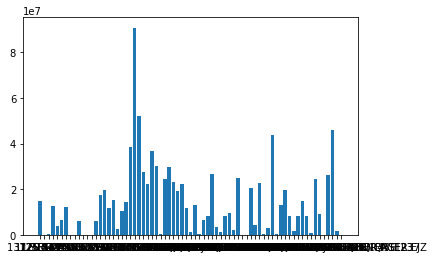

In [657]:
plt.bar(exits_range['match_name'],  exits_range['EXITS'])

In [658]:
## Find average exits count for each station for one day
exits_avg =  exits_range.groupby('match_name').EXITS.mean().astype(int).reset_index()
exits_avg.head(20)

,match_name,EXITS
0,116 ST 23,119281
1,125 ST 23,1648
2,125 ST 456,10681
3,125 ST ABCD,369221
4,135 ST 23,57879
5,135 ST BC,60437
6,137 ST-CITY COLLEGE 1,150517
7,145 ST 1,3276
8,145 ST ABCD,1013
9,149 ST-3 AV 25,73233


In [659]:
exits_avg[exits_avg['match_name'].str.contains('FLATBUSH AV')]

,match_name,EXITS
51,FLATBUSH AV 25,747780


In [660]:
exits_range[exits_range['match_name'].str.contains('116 ST 23')].EXITS.mean().astype(int)

119281

In [661]:
## Find average entries count for each station for one day
entries_avg =  entries_range.groupby('match_name').ENTRIES.mean().astype(int).reset_index()
entries_avg.head(20)

,match_name,ENTRIES
0,116 ST 23,176988
1,125 ST 23,2683
2,125 ST 456,5619
3,125 ST ABCD,412111
4,135 ST 23,332929
5,135 ST BC,86659
6,137 ST-CITY COLLEGE 1,52809
7,145 ST 1,4397
8,145 ST ABCD,844
9,149 ST-3 AV 25,208387


In [662]:
## Join entries and exits dataframes
merged_station_totals = pd.merge(entries_avg, exits_avg, on = 'match_name', how = 'inner')
merged_station_totals.head(20)

,match_name,ENTRIES,EXITS
0,116 ST 23,176988,119281
1,125 ST 23,2683,1648
2,125 ST 456,5619,10681
3,125 ST ABCD,412111,369221
4,135 ST 23,332929,57879
5,135 ST BC,86659,60437
6,137 ST-CITY COLLEGE 1,52809,150517
7,145 ST 1,4397,3276
8,145 ST ABCD,844,1013
9,149 ST-3 AV 25,208387,73233


In [663]:
## Add column with average foot traffic per day for each station during the Fall 2021 semester.
merged_station_totals['totals'] = merged_station_totals['ENTRIES'] + merged_station_totals['EXITS']
merged_station_totals.head()

,match_name,ENTRIES,EXITS,totals
0,116 ST 23,176988,119281,296269
1,125 ST 23,2683,1648,4331
2,125 ST 456,5619,10681,16300
3,125 ST ABCD,412111,369221,781332
4,135 ST 23,332929,57879,390808


In [664]:
sorted_totals = merged_station_totals.sort_values('totals', ascending = False)
sorted_totals.head(20)

,match_name,ENTRIES,EXITS,totals
22,34 ST 123ACE,80715194,58729562,139444756
54,GRAND CENTRAL-42 ST GS4567,5528439,11402352,16930791
25,42 ST PORT AUTH ACENQRS1237,8744516,7385912,16130428
60,PARK PLACE ACE123,6666906,8220809,14887715
26,47-50 STS ROCKEFELLER CENTER BDFM7,2461312,2224908,4686220
23,34 ST BDFMNQR,2367144,2076482,4443626
24,42 ST BDFM7,2078754,1469658,3548412
68,UNION SQUARE LNQR456,1913607,1494562,3408169
40,BOROUGH HALL R2345,1474079,935274,2409353
33,66 ST-LINCOLN CENTER 1,1209299,1072910,2282209


# Pickle Average Daily Foot Traffic Per Station Data
This will be used the next notebook to merge with CUNY campus dataframe.

In [665]:
sorted_totals.to_pickle('sorted_station_count_totals')

## Plot to see obvious outliers caused by errors, circle back, correct and clean data, repeat

<BarContainer object of 71 artists>

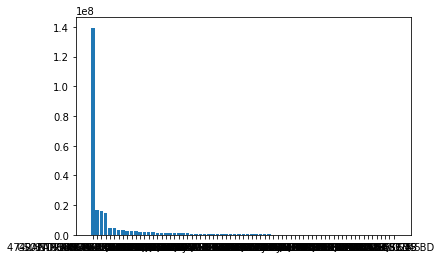

In [666]:
plt.bar(sorted_totals['match_name'], sorted_totals['totals'])

In [667]:
## Look into Courtlandt St. R -- an outlier? or does it connect to NJ via WTC and Brooklyn so it has high counts?
## Went back and deleted individual turnstiles that had measurements of more than 10 million for one time measurement
reindexed.head()

,DATE,match_name,TIME,ENTRIES,EXITS
,,,,sum,sum
0,07/31/2021,116 ST 23,01:00:00,31550141,17834119
1,07/31/2021,116 ST 23,05:00:00,31550176,17834226
2,07/31/2021,116 ST 23,09:00:00,31550514,17834440
3,07/31/2021,116 ST 23,13:00:00,31551239,17834919
4,07/31/2021,116 ST 23,17:00:00,31552273,17835668


In [668]:
reindexed[reindexed['match_name'].str.contains('CORTLANDT')].sort_values(("ENTRIES", "sum")).tail(30)

,DATE,match_name,TIME,ENTRIES,EXITS
,,,,sum,sum
63307,12/17/2021,CORTLANDT ST R,16:00:00,28876075,22761307
66453,12/24/2021,CORTLANDT ST R,00:00:00,28876316,22783704
66454,12/24/2021,CORTLANDT ST R,04:00:00,28876341,22783797
66455,12/24/2021,CORTLANDT ST R,08:00:00,28876456,22784008
66456,12/24/2021,CORTLANDT ST R,12:00:00,28876816,22784753
66457,12/24/2021,CORTLANDT ST R,16:00:00,28878048,22786172
63308,12/17/2021,CORTLANDT ST R,20:00:00,28878598,22763432
63747,12/18/2021,CORTLANDT ST R,00:00:00,28879079,22764418
63748,12/18/2021,CORTLANDT ST R,04:00:00,28879118,22764538


In [669]:
station_count_loc.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,station_loc,match_name,match_number,un_name_y,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,...,"(59 ST NQR456, 96)",59 ST NQR456,96,59 ST NQR456,40.762526,-73.967967,POINT (-73.96797 40.76253),0.71144,-1.290985,True


In [670]:
cort = station_count_loc[station_count_loc['match_name'].str.contains('CORTLANDT')].sort_values(("ENTRIES"))

In [671]:
cort.groupby('SCP').ENTRIES.mean().astype(int)

SCP
00-00-00       9237
00-00-01    4082854
00-02-00    3809984
00-02-01     738022
00-03-00     221829
00-03-02      22624
00-03-03    1708196
00-05-00     679218
00-05-01      13843
00-05-02    1698192
00-05-03     739018
01-00-00     274568
01-00-01     191109
01-00-02      17780
01-00-03     154379
01-03-00     243958
01-03-01     394545
01-05-00        864
01-05-01     524288
02-00-00     929849
02-00-01    1023975
02-00-02      23433
02-01-00    1086606
02-01-01     342207
02-01-02    1874201
02-03-00    1854315
02-03-01      89409
02-03-02    1345406
02-03-03    1505197
03-00-00    1175312
03-00-01     178936
03-00-02     262242
03-00-03     212520
03-05-00     852208
03-05-01     262144
Name: ENTRIES, dtype: int64

In [672]:
## Now look at 23rd St?
reindexed[reindexed['match_name'].str.contains('23 ST 1')].sort_values(("ENTRIES", "sum")).tail(30)

,DATE,match_name,TIME,ENTRIES,EXITS
,,,,sum,sum
532,08/01/2021,23 ST 1,13:00:00,40091816,7457181
533,08/01/2021,23 ST 1,17:00:00,40093026,7458312
534,08/01/2021,23 ST 1,21:00:00,40093889,7459149
979,08/02/2021,23 ST 1,01:00:00,40094220,7459446
980,08/02/2021,23 ST 1,05:00:00,40094269,7459513
981,08/02/2021,23 ST 1,09:00:00,40095171,7460552
982,08/02/2021,23 ST 1,13:00:00,40096039,7461608
983,08/02/2021,23 ST 1,17:00:00,40097405,7462759
984,08/02/2021,23 ST 1,21:00:00,40098621,7463805


In [673]:
twent_three = station_count_loc[station_count_loc['match_name'].str.contains('23 ST 1')].sort_values(("ENTRIES"))
twent_three.groupby('SCP').ENTRIES.mean().astype(int)

SCP
00-00-00    4964491
00-00-01    8532150
00-00-02    8997596
00-06-00     568618
00-06-01     408542
00-06-02     262144
01-00-00     130709
01-00-01     187110
01-00-02    2596794
01-00-03     184810
Name: ENTRIES, dtype: int64

In [674]:
## It's pooling data from 231st St with 23rd St. We don't want data from 231st ST so this needs to be dropped!
twent_three.head(30)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,station_loc,match_name,match_number,un_name_y,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
754406,R132,R190,01-00-00,23 ST,1,IRT,07/31/2021,01:00:00,REGULAR,115407,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754407,R132,R190,01-00-00,23 ST,1,IRT,07/31/2021,05:00:00,REGULAR,115412,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754408,R132,R190,01-00-00,23 ST,1,IRT,07/31/2021,09:00:00,REGULAR,115423,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754409,R132,R190,01-00-00,23 ST,1,IRT,07/31/2021,13:00:00,REGULAR,115455,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754410,R132,R190,01-00-00,23 ST,1,IRT,07/31/2021,17:00:00,REGULAR,115496,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754411,R132,R190,01-00-00,23 ST,1,IRT,07/31/2021,21:00:00,REGULAR,115535,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754412,R132,R190,01-00-00,23 ST,1,IRT,08/01/2021,01:00:00,REGULAR,115546,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754413,R132,R190,01-00-00,23 ST,1,IRT,08/01/2021,05:00:00,REGULAR,115553,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754414,R132,R190,01-00-00,23 ST,1,IRT,08/01/2021,09:00:00,REGULAR,115559,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True
754415,R132,R190,01-00-00,23 ST,1,IRT,08/01/2021,13:00:00,REGULAR,115573,...,"(23 ST 1, 100)",23 ST 1,100,23 ST 1,40.744081,-73.995657,POINT (-73.99566 40.74408),0.711118,-1.291468,True


In [675]:
reindexed[reindexed['match_name'].str.contains('BOROUGH')].sort_values(("ENTRIES", "sum")).tail(30)

,DATE,match_name,TIME,ENTRIES,EXITS
,,,,sum,sum
64590,12/20/2021,BOROUGH HALL R2345,03:00:00,44534781,29848137
64592,12/20/2021,BOROUGH HALL R2345,07:00:00,44534954,29848746
64593,12/20/2021,BOROUGH HALL R2345,11:00:00,44536755,29852847
64594,12/20/2021,BOROUGH HALL R2345,15:00:00,44539095,29855352
64595,12/20/2021,BOROUGH HALL R2345,19:00:00,44543826,29857974
64596,12/20/2021,BOROUGH HALL R2345,23:00:00,44544796,29858850
65053,12/21/2021,BOROUGH HALL R2345,03:00:00,44544965,29859045
65054,12/21/2021,BOROUGH HALL R2345,07:00:00,44545132,29859714
65055,12/21/2021,BOROUGH HALL R2345,11:00:00,44546752,29863493


In [676]:
bor_hall = station_count_loc[station_count_loc['match_name'].str.contains('BOROUGH')].sort_values(("ENTRIES"))
bor_hall.groupby('SCP').ENTRIES.mean().astype(int)

SCP
00-00-00     107410
00-00-01    2477257
00-03-00     377941
00-03-01    5456733
00-06-01    3424428
01-00-00     887639
01-00-01     414574
01-00-02     191540
01-06-00    1010001
02-00-00     667972
02-00-01     535656
02-00-02    2719923
02-00-03     468222
02-00-04     163166
02-00-05    4502227
02-00-06      92937
02-05-00       2337
02-05-01          5
03-00-00    5647086
03-00-02    6655587
03-00-03      24411
03-00-04    7992350
03-00-05      76627
Name: ENTRIES, dtype: int64

In [677]:
bor_hall.tail(30)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,...,station_loc,match_name,match_number,un_name_y,station_latitude,station_longitude,geometry,lat_radians_station,long_radians_station,half_mile
234544,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/20/2021,03:00:00,REGULAR,8017411,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234545,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/20/2021,07:00:00,REGULAR,8017416,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234546,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/20/2021,11:00:00,REGULAR,8017487,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234547,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/20/2021,15:00:00,REGULAR,8017550,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234548,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/20/2021,19:00:00,REGULAR,8017674,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234549,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/20/2021,23:00:00,REGULAR,8017706,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234550,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/21/2021,03:00:00,REGULAR,8017707,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234551,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/21/2021,07:00:00,REGULAR,8017713,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234552,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/21/2021,11:00:00,REGULAR,8017772,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True
234553,R604,R108,03-00-04,BOROUGH HALL,2345R,IRT,12/21/2021,15:00:00,REGULAR,8017834,...,"(BOROUGH HALL R2345, 94)",BOROUGH HALL R2345,94,BOROUGH HALL R2345,40.693219,-73.989998,POINT (-73.99000 40.69322),0.710231,-1.291369,True


In [678]:
sorted_totals[sorted_totals['match_name'].str.contains("FLAT")]

,match_name,ENTRIES,EXITS,totals
51,FLATBUSH AV 25,903385,747780,1651165
